In [19]:
from tcre.env import *
from tcre.nb import utils
import pathlib as pl
from IPython.display import display, HTML
utils.FORCE_NB_RELOAD = True

def get_cell(path, name):
    return utils.get_tag_html(path, name, prefix='summary')

def show_cell(path, name):
    return display(HTML(get_cell(path, name)[0]))

def plink(path, use_path_name=False):
    rel = path.relative_to(REPO_DIR)
    name = rel if use_path_name else path.name
    return '<a href="{}">{}</a>'.format(pl.Path('..') / rel, name)

META_DATA_DIR = pl.Path(REPO_DATA_DIR) / 'meta'
SRC_TCRE = pl.Path(REPO_DIR) / 'src' / 'tcre'
SRC_TRAIN = SRC_TCRE / 'exec' / 'v1' / 'train.py'
SRC_MODEL = SRC_TCRE / 'exec' / 'v1' / 'model.py'
NB_PIPELINE = pl.Path(REPO_DIR) / 'pipeline'
NB_ENTREZ_IMPORT = NB_PIPELINE / '01-entrez-import.ipynb'
NB_PMCOA_IMPORT = NB_PIPELINE / '01-pmcoa-import.ipynb'
NB_PRO_IMPORT = NB_PIPELINE / '02-meta-import-pro.ipynb'
NB_CL_IMPORT = NB_PIPELINE / '02-meta-import-cl.ipynb'
NB_META_CT = NB_PIPELINE / '03-meta-cell-types.ipynb'
NB_META_TF = NB_PIPELINE / '03-meta-transcription-factors.ipynb'
NB_META_CK = NB_PIPELINE / '03-meta-cytokines.ipynb'
NB_META_PR = NB_PIPELINE / '03-meta-proteins.ipynb'
NB_PHEN_INF = NB_PIPELINE / 'experiments' / 'eda-phenotype.ipynb'
NB_PRTN_TKN = NB_PIPELINE / 'experiments' / 'protein-tokenization.ipynb'
NB_LBLMDL_V2 = NB_PIPELINE / 'experiments' / 'label-model-training' / 'label-model-training-v2.ipynb'
NB_DEV_GRID = NB_PIPELINE / '10-modeling-rnn-dev.ipynb'
NB_TRAIN_MARGINALS = NB_PIPELINE / '09-candidate-lfs.ipynb'
NB_END_TRAIN = NB_PIPELINE / '10-modeling-rnn-all.ipynb'
NB_ANALYSIS_SCORES = NB_PIPELINE / '12-analysis-scores.ipynb'

# **NOTE** if the markdown substitution isn't working, make sure the notebook is "Trusted" at the top

## Project Summary

Top-level stats, motivations, and results that are otherwise difficult to compile from individual project files.

Contents:

- [Corpora](#corpora)
- [Controlled Vocabularies](#controlled-vocabularies)
- [Entity Recognition](#entity-recognition)
- [Phenotype Inference](#phenotype-inference)
- [Candidate Generation](#candidate-generation)
- [Candidate Annotation](#candidate-annotation)
- [Labeling Functions](#labeling-functions)
- [Strong Supervision](#strong-supervision)
- [Weak Supervision](#weak-supervision)
- [Relation Extraction](#relation-extraction)
- [TODO](#todo)

<h1><a id='corpora'>Corpora</a></h1>

There are two main corpora used:
- A smaller dev corpus built from a targeted Entrez query
- A larger PMC open acess corpus filtered for key words/phrases

### Dev Corpus

Notebook: {{plink(NB_ENTREZ_IMPORT)}}

This was collected using the Entrez api:

```python
handle = Entrez.esearch(db='pmc', sort='relevance', retmode='xml', term=query)
Entrez.efetch(db='pmc', rettype="full", retmode='xml', id=Entrez.read(handle))
```

Results were sorted by relevance and arbitrarily limited to the first ~20k documents (out of 124,720 as of 2019-03-11).  The query associated with these results was:

In [3]:
show_cell(NB_ENTREZ_IMPORT, 'query')

The collected documents contain a mix of full text and abstract-only articles.  Frequencies: 

In [4]:
show_cell(NB_ENTREZ_IMPORT, 'textct')

### Notes on PMC Queries

To compare results for keyword searchs vs MeSH terms, here are few key result set sizes (as of 2019-07-08):


- Target Documents: ```Humans AND T-cells AND cytokines AND differentiation AND induction```
    - With keywords:
        - PMC Search: *(human) AND ( (t cell) OR (t lymphocyte) ) AND (cytokine) AND ((differentiate) OR (differentiation) OR (differentiated)) AND ((polarization) OR (polarize) OR (induce) OR (induction))*
        - Results: **129,982**
    - With MeSH terms:
        - PMC Search: ```"humans"[MeSH Terms] AND ("t lymphocytes"[MeSH Terms] OR "t lymphocyte subsets"[MeSH Terms]) AND "cytokines"[MeSH Terms] AND "cell differentiation"[MeSH Terms] AND "transcriptional activation"[MeSH Terms]```
        - Results: **16**
- Target Documents: Humans AND T-cells AND cytokines AND differentiation 
    - PMC Search: ```"humans"[MeSH Terms] AND ("t lymphocytes"[MeSH Terms] OR "t lymphocyte subsets"[MeSH Terms]) AND "cytokines"[MeSH Terms] AND "cell differentiation"[MeSH Terms]```
    - Results: **1,544**
- Target Documents: Humans AND T-cells AND differentiation 
    - PMC Search: ```"humans"[MeSH Terms] AND ("t lymphocytes"[MeSH Terms] OR "t lymphocyte subsets"[MeSH Terms]) AND "cell differentiation"[MeSH Terms]```
    - Results: **3,222**
- Target Documents: Humans AND T-cells AND cytokines
    - PMC Search: ```"humans"[MeSH Terms] AND ("t lymphocytes"[MeSH Terms] OR "t lymphocyte subsets"[MeSH Terms]) AND "cytokines"[MeSH Terms]```
    - Results: **16,874**
- Target Documents: Humans AND T-cells AND induction
    - PMC Search: ```"humans"[MeSH Terms] AND ("t lymphocytes"[MeSH Terms] OR "t lymphocyte subsets"[MeSH Terms]) AND "transcriptional activation"[MeSH Terms]```
    - Results: **378**
- Target Documents: Humans AND T-cells
    - PMC Search: ```"humans"[MeSH Terms] AND ("t lymphocytes"[MeSH Terms] OR "t lymphocyte subsets"[MeSH Terms])```
    - Results: **48,059**
    
MeSH Terms Above:

- [Cell Differentiation](https://meshb.nlm.nih.gov/record/ui?ui=D002454)
- [Humans](https://meshb.nlm.nih.gov/record/ui?ui=D006801)
- [T-Lymphocytes](https://meshb.nlm.nih.gov/record/ui?ui=D013601)
- [Transcriptional Activation](https://meshb.nlm.nih.gov/record/ui?ui=D015533)
- [Cytokines](https://meshb.nlm.nih.gov/record/ui?ui=D016207)

### Primary Corpus

Notebook: {{plink(NB_PMCOA_IMPORT)}}

This was extracted from the PMC OA subset.  Documents are filtered based on appearance of the following key words/phrases:

In [4]:
show_cell(NB_PMCOA_IMPORT, 'searchterms')

A first pass over all documents aggregates indicators for the above string presence and other meta data for each document.  Results shown below:

In [5]:
show_cell(NB_PMCOA_IMPORT, 'metainfo')

The search terms a grouped into coarser categorizations (e.g. "has common CD markers" = "cd3" or "cd4" or "cd8")
and frequencies of some relevant ones (out of ~2.5 docs) can be seen here:

In [6]:
show_cell(NB_PMCOA_IMPORT, 'termfreq')

Target documents are then extract for some combination of matches above to give resulting datasets like this (first 1k rows):

In [7]:
show_cell(NB_PMCOA_IMPORT, 'extractinfo')

NOTE: As of yet, I haven't done anything more with this.  I was planning though to move forward with a corpus filtered by the criteria:
- Must contain the word "Human"
- Must contain the word "T cell" (or nearby variants)
- Must contain one of CD3, CD4 or CD8 

This restricts the 2.5M documents to just ~48k.

<h1><a id='controlled-vocabularies'>Controlled Vocabularies</a></h1>

Ontologies or other sources are used separately to build vocabulary tables for the following entity types:

- Surface Proteins ([Protein Ontology (PRO)](https://paperpile.com/app/p/3f1c6c43-0bca-0760-a9e0-1ff7016060b0))
    - PRO import notebook: {{plink(NB_PRO_IMPORT)}}
    - Integration notebook: {{plink(NB_META_PR)}} (filters to immunology marker proteins e.g. CD markers)
    - All nodes imported descend from [PR_000000001](http://purl.obolibrary.org/obo/PR_000000001)
    - When using it for surface marker token matching, any subtree with a node including a label or synonym starting with "CD" is extracted 
    - The result from the importation enforces that synonyms are unique by prioritizing based on synonym type (e.g. BROAD = lowest priority, EXACT = high priority)
- Cell Types ([Cell Ontology (CL)](https://paperpile.com/app/p/7706c6ce-ba79-067b-86b9-deb6ce967dd6))
    - CL import notebook: {{plink(NB_CL_IMPORT)}} 
    - Integration notebook: {{plink(NB_META_CT)}} (incorporates sources beyond CL)
    - All imported terms descend from [CL_0000084](http://purl.obolibrary.org/obo/CL_0000084)
    - Again, synonym uniqueness is enforced by resolving conflicts based on synonym type (and arbitrarily for ties)
- Cytokines ([Cytokine Registry (CKR)](https://www.immport.org/resources/cytokineRegistry))
    - CKR import notebook {{plink(NB_META_CK)}}
    - In this case, as CKR isn't a very structured ontology, terms and synonyms are imported much like other sources of cytokine synonyms 
- Transcription Factors ([The Human Transcription Factors](https://paperpile.com/app/p/962005d3-58ab-063c-ac54-abebd479a0d9))
    - TF integration notebook: {{plink(NB_META_TF)}}

In each case:

- Additional sources of aliases for terms (e.g. MyGene) are mapped to the primary source (i.e. those linked above)
- Most sources have a list of manual items appended from tables in {{plink(META_DATA_DIR / 'raw', use_path_name=True)}}
- All synonyms are filtered to those with a length greater than 3 or 4 characters (depending on the type)
    - This is also followed a by blacklist of synonyms to exclude (e.g. "OUT", "GENESIS", "IFI", etc.) that are too ambiguous to use for token matching

Resulting tables are all serialized in {{plink(META_DATA_DIR, use_path_name=True)}}

<h1><a id='entity-recognition'>Entity Recognition</a></h1>

TBD

- Outline tokenization and entity tagging process
- Show ScispaCy JNLPBA tagger examples
    

<h1><a id='cell-phenotype-inference'>Phenotype Inference</a></h1>

This analysis was an aside to the issue discussion here: https://github.com/hammerlab/t-cell-relation-extraction/issues/2

The problem that motivated this work was that currently, all cell type mentions are based on exact token sequence matches via [SpaCy pattern matchers](https://spacy.io/usage/rule-based-matching) (EntityRuler specifically).  To expand this to mentions of T cell types that don't necessarily include a label like "Th1", this analysis was an attempt to see how often cells are instead referenced by surface marker expression.

This is also related to the ontology expansion discussion [here](https://github.com/hammerlab/t-cell-relation-extraction/issues/2#issuecomment-501504614) as a precursor to using something like HiExpan first involves building a set of noun phrases to place in an ontology, and using the JNLPBA-trained tagger won't work for that.  For example, on the 20K document dev corpus the tagger produces about **70K** unique noun phrases that either have a substring like "T cell" or "T-lymphocyte" OR a substring matching any one of the 627 synonyms for T cell types ("Th1", "MAIT", "iTreg", etc.).  There are only **136** T cell terms in CL meaning that even if the 70K terms from the tagger include cell types not in CL, it would still have to be highly compressed before applying it to taxonomy expansion.

The essence of the analysis then was to figure out the following things: 

- Which naming modality is more common, ```CD4+CD25+FoxP3+ T cells``` or ```CD4+CD25+FoxP3+ Treg cells```?
- If the modality above with no "Treg" label is very common, can it be shown that the expression markers can be used to cluster the mentions near other mentions where the label (i.e. a ground truth) is present.

The process for doing this in the notebook {{plink(NB_PHEN_INF, use_path_name=True)}} includes:

- Pull a list of overlapping tags from both the JNLPBA model and the T cell type token matcher (using 627 aliases)
- Filter to tags that have exactly one token phrase match or a substring like "T cell" (must match case-insensitive regex ```t[- ]?(?:cell|lymphocyte)```)
- Re-tokenize protein strings
    - This is in the separate ```ptkn``` src package (usage example: {{plink(NB_PRTN_TKN, use_path_name=True)}})
- Visualize noun phrases with a known cell type label
- Visualize an embedding based on marker expression (with and without a known cell type label)

### Naming Modality Frequencies

To answer the ```CD4+CD25+FoxP3+ T cells``` vs ```CD4+CD25+FoxP3+ Treg cells``` question, here are relevant findings:

In [8]:
# This shows the number of unique noun phrases that have zero, one, or more than one substring
# matching a known T cell type synonym
show_cell(NB_PHEN_INF, 'uniqct1')

In [9]:
# This shows the same as the above but also split by how many matches the
# phrase has on '(CD\d+|CCR\d+|CXCR\d+|IL\-\d+|TNF|TGF|IFN)' as a rough indication
# of whether or not surface markers are present (note that CD3, CD4 and CD8 markers are ignored)
show_cell(NB_PHEN_INF, 'uniqct2')

In [10]:
# Same as above but with total tag counts rather than unique tags
show_cell(NB_PHEN_INF, 'totalct1')

For a more intuitive sense of what these buckets above mean, here are examples:
    
match_ct_bin | marker_ct_bin | examples | desc   | approx. frequency (from table above)
-------------|---------------|----------|--------|-----------------------------
none | none  | human primary T cells | No type or marker indication | 50%
none | none  | CD4+ T cells | CD3, CD4, and CD8 are generally not informative markers so they are ignored | 50%
none | one   | CD45RbHi T cells | One informative marker, no type indication | 5%
none | 2+    | CX3CR1+CD45RO+CD8+ T cells | No type, several markers | 1.1%
one  | none  | Treg cells | Type only | 38%
one  | one   | CD39- Tregs | Type and single informative marker | 2.8 %
one  | 2+    | CD4+CD25HighCD127- Treg cells | Type + several markers | .8 %
2+   | none  | Th1 and Th17 cells | Tagger lumps multiple cell types together sometimes | 2.5%
2+   | one   | TNF-α producing Th1 and Tc1 cells | Sometimes markers and multiple cells are extracted as long phrases | .06%

### tl;dr

Together, this implies that of ~70K T cell phrases, 64% do NOT have a nice, neat label to match on and that this percentage stays roughly the same when you further restrict to phrases with at least one informative (i.e. not CD[348]) surface marker

### Signed Surface Marker Frequencies

The protein tokenizer gives for each marker and normalizes them to common names in PRO, CKR or the TF list:

In [11]:
show_cell(NB_PHEN_INF, 'tknex')

Applying this to all mentions with a discernable cell type ("CD4+CD25+FoxP3+ **Treg** cells") gives:


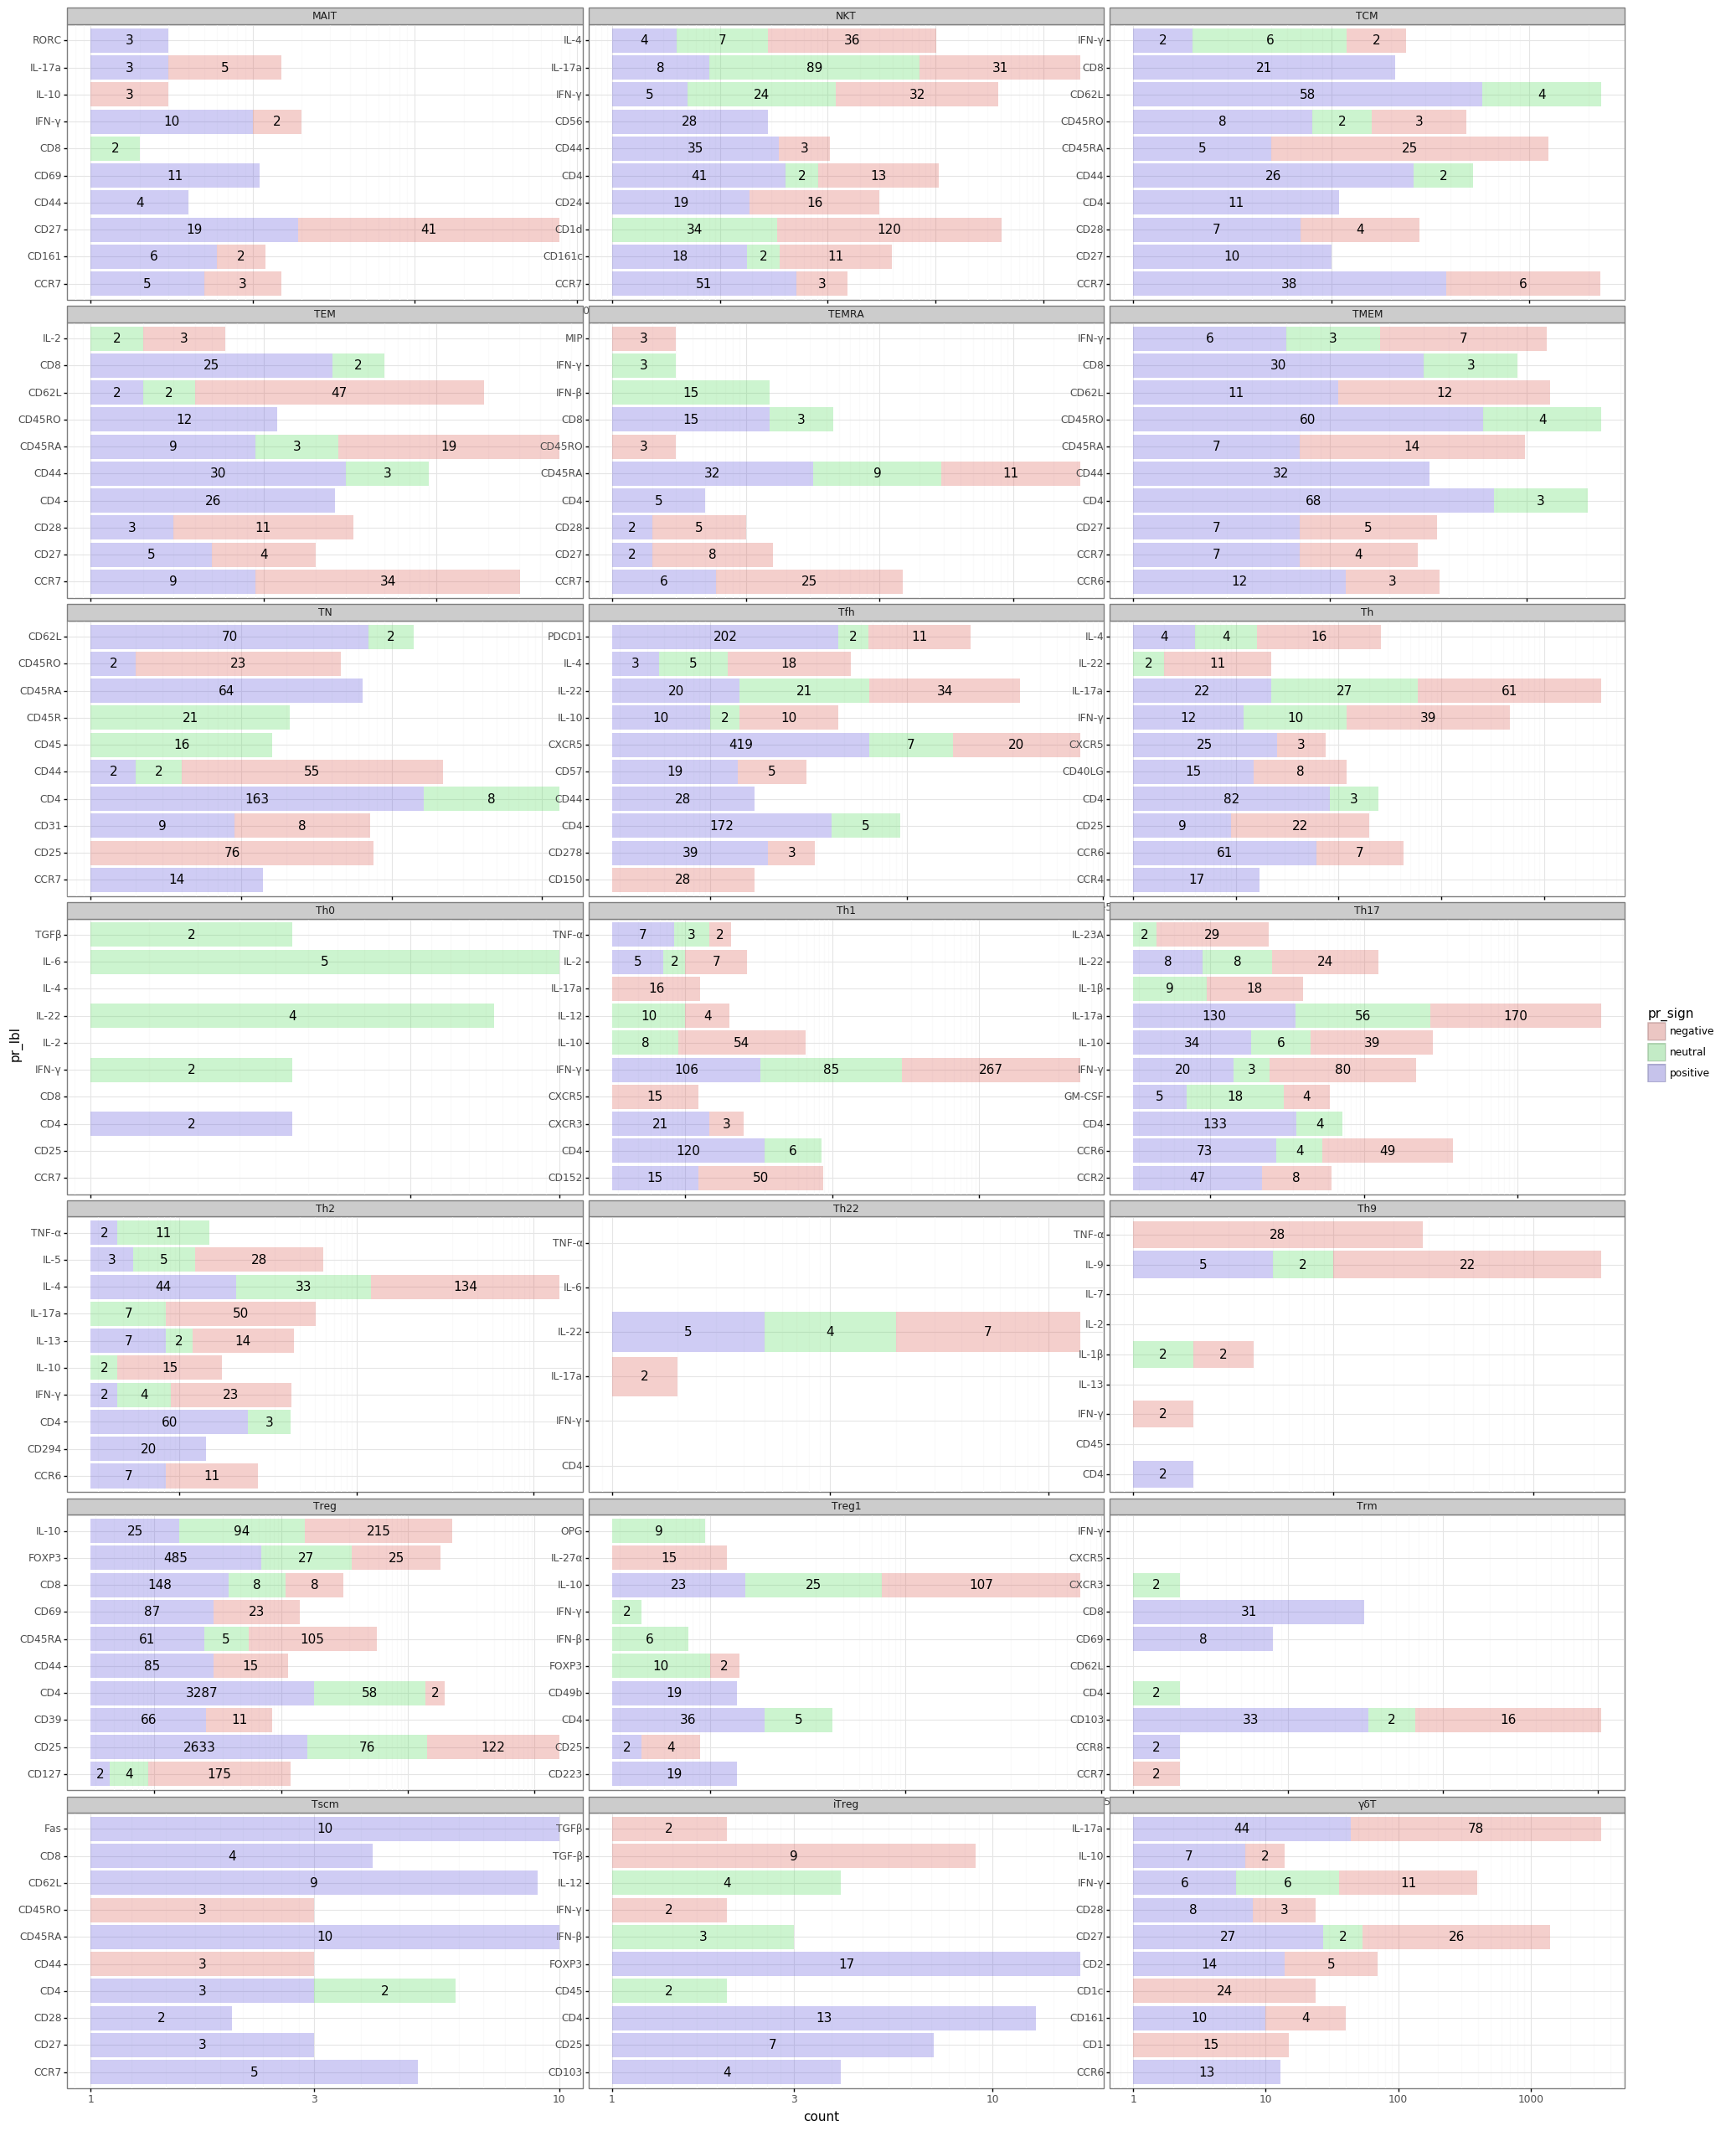

In [12]:
show_cell(NB_PHEN_INF, 'gtplot')

This is a bit noisy but otherwise seems like a good place from which to assume that the association between cell types and relevant markers is strong in this approach (i.e. clustering of the mentions should be meaningful).

### Clustering

The last step of this analysis was to try visualize how well relating mentions based on surface markers could work.  Here, the markers are associated with a sign (-1, 0, or 1) based on how they appeared in text and then mapped to (-1, 0, 1, 2) in an indicator matrix with 0 representing marker absence, 1 being neutral, and 2 being positive.  An embedding of this matrix overlayed with cell type looks like this ([interactive version](https://plot.ly/~eczech/2/mait-nkt-none-tcm-tem-temra-tmem-tn-tfh-th-th0-th1-th17-th2-th22-th9-treg-treg1-/)):


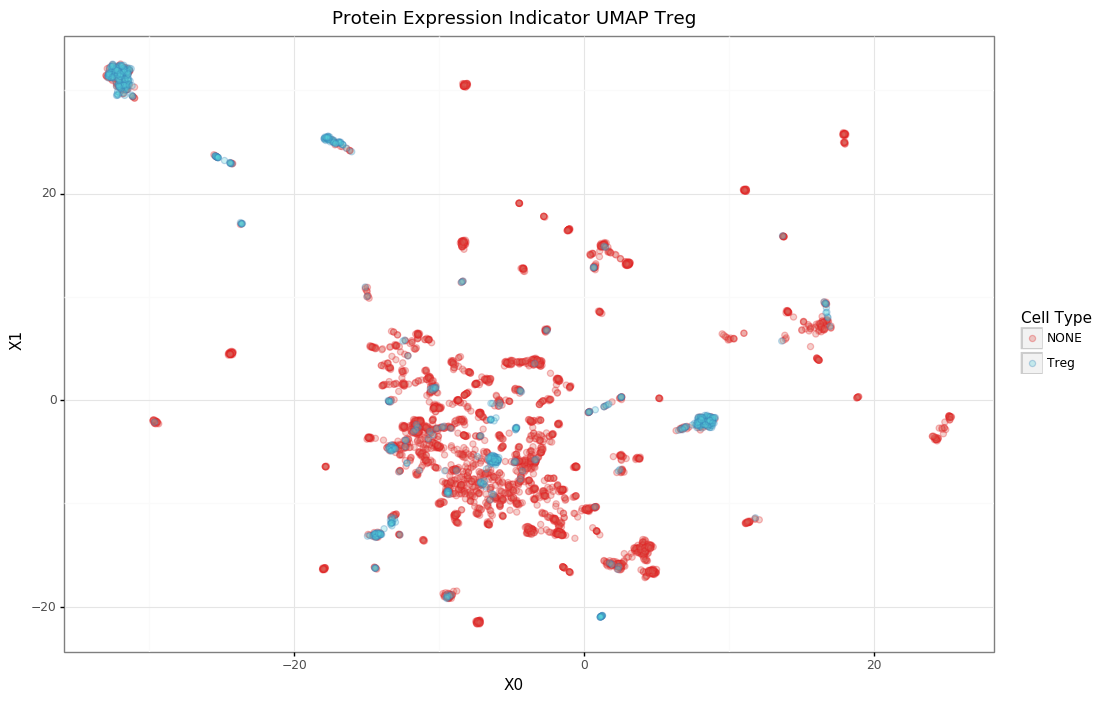

In [98]:
show_cell(NB_PHEN_INF, 'umaptreg')

The overlap between the blue and red dots suggest that the red dots could accurately be associated with the cell type label in the blue dots (Treg in this case).  The bigger clusters represent alternative contexts/conventions like:

- CD4+ CD25+ + (one or more other markers)
- CD4+ CD25+ FoxP3+ + (one or more other markers)
- CD25+ CD127- 
- CD44- CD62L+ Treg (mice)
- IFN- IL-17- Tregs (functional profiling)

Here are some additional mentions for other cell types that cluster closely and would otherwise be difficult to match without appealing to a parse and normalization of the associated markers:

- CD4+CD45RO+CXCR5+ **Tfh** cells [[PMC5519210]()]
    - neighbors:
        - CXCR5+ expressing CD4+CD45RO+ T cells [[PMC4504540]()]
        - memory (CD45RO+) CXCR5+CD4+ T cells [[PMC6409398]()]
        - CXCR5hiBTLAhiCD4+ T cells [[PMC4972135]()]
- VP1-specific CD69+/CD103+ tissue-resident memory (**TRM**) cells [[PMC5056763]()]
    - neighbors:
        - human CD69+CD103+ CD8 T cells [[PMC5461007]()]
        - SIINFEKL-specific tetramer-binding resident memory-like CD103+CD69+CXCR3+ CD8 T cells [[PMC5173246]()]
        - intrahepatic CD45RA−CD69+CD103+ CD8 T cells [[PMC5461007]()]
- Tscm CD4+CD45RA+CD45RO−CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+ T (**Tscm**) cell [[PMC4902324]()]
    - neighbors:
        - CD4+CD45RA+CD45RO–CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+T-Cell Subsets [[PMC4902324]()]
        - CD4+CD45RA+CD45RO−CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+ T cells [[PMC4902324]()]
- **Th2** (IL-4+ IFN-γ−) cells [[PMC2212016]()]
    - neighbors:
        - IFN-γ–IL-4+CD4+ T cells [[PMC3767795]()]
        - IL-4+IFN-γ− NKT2 cells [[PMC2193332]()]
        - IL-4/IFN-γ-producing T cells [[PMC4718521]()]

<h1><a id='candidate-generation'>Candidate Generation</a></h1>

TBD

- Candidate Generation
- Explain how candidates are paired within sentence and stored in snorkel db

<h1><a id='candidate-annotation'>Candidate Annotation</a></h1>

TBD

- Give stats on initial BRAT annotations and relation classes
- Provide info on test set annotations (outside of BRAT)

<h1><a id='labeling-functions'>Labeling Functions</a></h1>

The process for building labeling functions so far has been:

1. Take notes on text patterns that came up while doing the original dev set annotations
2. Try to account for overlap in those patterns and coalesce those that are very similar (though I didn't worry about this too much since correlations between them should hypothetically not be a problem)
3. Apply these patterns to the dev set in {{plink(NB_TRAIN_MARGINALS, use_path_name=True)}}
    - I started with a single task (inducing cytokines) and initially translated only a fraction of my notes on patterns into labeling functions (maybe 15 or so rules).  Each of these had very low coverage (at best 4 or 5 candidates out of ~400).
    - Next, I slowly added more rules (up to about 50) and began to create something like a regex templating language (out of necessity as the boilerplate was getting annoying to manage).  Example:
        - ```r'{A}{wc_md}{r_push_v}{wc_md}{B}{wc_md}{r_diff_n}'```
            - "A" and "B" are the candidate positions (A = cytokine, B = cell type)
            - "**wc_md**" is a medium size wildcard placeholder (literally ```[^;]{0,50}```)
            - "**r_push_v**" is a set of words like "driver", "promoter", "regulator" with different parts of speech as well (drives, driving, driven)
            - "**r_diff_n**" is a similar set of words with a sense close to "differentiation" (polarization, induction, generation, etc.)
            - This example corresponds to phrases like this found in annotation:
                - *predominance of [cytokine] drives [cell type] differentiation*
                - *[cytokine] regulates [cell type] differentiation*
        - This part was time consuming primarily due to:
            - Coming up with synonymous words and making sure they are applied to other patterns
            - Periodically needing to consolidate patterns and synonyms 
            - Needing to build the labeling functions dynamically based on configurations (i.e. literally writing a separate function for each pattern would have been hard to change)
4. After reaching reasonable coverage and accuracy (see the ```LF_ind*_txtptn_[pos|neg]_all``` function stats below), I also added LFs for:
    - Distant supervision from iX
        - I was not using every single link in iX and instead filtering to those that appear in >= N distinct publications
            - N=8 is ultimately what I settled on, but it may be worth adding multiple LFs with different values
    - Heuristics
        - Some successful heuristics included:
            - Is there an entity between the entities in question?
            - Are the entities more than X characters apart?
            - Using LFs from opposing tasks as negative examples (secreted vs inducing cytokines are almost always exclusive)
        - All of the above were good negative indicators and worked well when combined with either the iX or the text pattern based rules (which are targeted towards positive examples)
        
These statistics below show the empirical accuracy + coverage on the dev set (split 1):

In [13]:
show_cell(NB_TRAIN_MARGINALS, 'lfstats')

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Empirical F1
LF_indck_comp_imexpresso_nonneg,0,0.020000,0.020000,0.020000,1,2,0,16,0.894737,0.500000
LF_indck_comp_neg_sec,1,0.115789,0.115789,0.114737,0,0,5,105,0.954545,NaN
LF_indck_comp_xor,2,0.249474,0.249474,0.248421,63,67,3,104,0.704641,0.642857
LF_indck_dsup_imexpresso,3,0.149474,0.149474,0.143158,16,13,3,110,0.887324,0.666667
LF_indck_heur_closer_ck_to_ct,4,0.346316,0.346316,0.250526,0,0,34,295,0.896657,NaN
LF_indck_heur_closer_ct_to_ck,5,0.258947,0.258947,0.160000,0,0,9,237,0.963415,NaN
LF_indck_heur_closer_ref,6,0.425263,0.425263,0.316842,0,0,41,363,0.898515,NaN
LF_indck_heur_complex_cand_01,7,0.948421,0.948421,0.831579,0,0,133,768,0.852386,NaN
LF_indck_heur_complex_cand_02,8,0.725263,0.725263,0.611579,0,0,97,592,0.859216,NaN
LF_indck_heur_distref,9,0.253684,0.253684,0.135789,0,0,6,235,0.975104,NaN


<h1><a id='strong-supervision'>Strong Supervision</a></h1>

To further improve labeling function accuracy, I opted not to create more advanced heuristics and instead focused on training supervised models on the dev set.  I tried searching over the following model configuration space:

1. Entity marker strategy
    - There are several ways to "mark" entities for RNNs applied to relation extraction:
        - TODO: add citations 
        - Enclose the entity spans in special characters
            ```IL-4 induces Th2 cells``` --> ```<< IL-4 >> induces [[ Th2 ]] cells```
        - Enclose off-target entities in different characters
            ```IL-4 does not induce Th1 cells but does induce Th2 cells``` --> ```<< IL-4 >> does not induce || Th1 || cells but does induce [[ Th2 ]] cells```
        - Replace the actual entity tokens with something generic
            ```IL-4 induces Th2 cells``` --> ```CYTOKINE induces PHENOTYPE cells```
2. Embeddings
    - Frozen pre-trained word2vec ([Pyysalo et al. 2013](http://bio.nlplab.org/))
    - Initialized pre-trained word2vec 
    - From scratch
3. Position Feature Embedding
    - Following [Zeng et al. 2014](), relative distances from each of the two entities are added as separate features in a learned embedding of some pre-configured size (generally ~10 dimensional)
4. Regularization
    - Dropout
    - Weight Decay
    - Structural (parameter count)
    
The following choices above are incorporated in the script {{plink(SRC_TRAIN, use_path_name=True)}}.  The model itself is defined in {{plink(SRC_MODEL, use_path_name=True)}}.  The notebook used for training is {{plink(NB_DEV_GRID, use_path_name=True)}}.

### Features

Example features generated are shown below for one combination of entity marking/swapping strategies:

In [14]:
# The "e0_dist" and "e1_dist" sequences show relative token distance to entities and 
# the "text" field shows results after marking
show_cell(NB_LBLMDL_V2, 'features')

,id,label,e0_dist,e0_text,e1_dist,e1_text,token_indices,text,word_indices
0,30167,1,"[-1, -1, 0, 1, 1, 2, 3, 4, 5, 5, 6, 7, 7, 8, 9, 10, 11, 11, 12, 13, 14, 15, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 26, 27, 28, 28, 29, 30]",IL-12,"[-28, -28, -27, -26, -26, -25, -24, -23, -22, -22, -21, -20, -20, -19, -18, -17, -16, -16, -15, -14, -13, -12, -12, -11, -9, -8, -7, -6, -5, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3]",TH1,"[0, 0, 1, 2, 2, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12, 12, 13, 14, 15, 16, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 28, 29, 29, 30, 31]","[<, @, IL-12, @, >, induces, not, only, |, @, Ifng, @, |, expression1, but, also, |, *, T, -, bet, *, |, ,, which, promotes, the, survival, and, proliferation, of, differentiating, <, #, TH1, #, >, cells, .]","[None, None, 0, None, None, 1, 2, 3, None, None, 4, None, None, 5, 6, 7, None, None, 8, 9, 10, None, None, 11, 13, 14, 15, 16, 17, 18, 19, 20, None, None, 21, None, None, 22, 23]"
1,30168,0,"[-7, -7, -6, -5, -5, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 22, 23, 24]",Ifng,"[-28, -28, -27, -26, -26, -25, -24, -23, -22, -22, -21, -20, -20, -19, -18, -17, -16, -16, -15, -14, -13, -12, -12, -11, -9, -8, -7, -6, -5, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3]",TH1,"[0, 0, 1, 2, 2, 3, 4, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12, 12, 13, 14, 15, 16, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 28, 29, 29, 30, 31]","[|, @, IL-12, @, |, induces, not, only, <, @, Ifng, @, >, expression1, but, also, |, *, T, -, bet, *, |, ,, which, promotes, the, survival, and, proliferation, of, differentiating, <, #, TH1, #, >, cells, .]","[None, None, 0, None, None, 1, 2, 3, None, None, 4, None, None, 5, 6, 7, None, None, 8, 9, 10, None, None, 11, 13, 14, 15, 16, 17, 18, 19, 20, None, None, 21, None, None, 22, 23]"
2,30169,1,"[-4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 22, 22, 23, 24, 25, 26, 27]",TGFβ,"[-25, -24, -23, -22, -22, -21, -20, -20, -19, -18, -17, -17, -16, -15, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 5, 6]",Th17,"[0, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 8, 9, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 26, 26, 27, 28, 29, 30, 31]","[In, mice, ,, <, @, TGFβ, @, >, together, with, |, @, IL6, @, |, can, activate, antigen, -, responsive, naïve, CD4, +, T, cells, to, develop, into, <, #, Th17, #, >, cells, [, 39, ], .]","[0, 1, 2, None, None, 3, None, None, 4, 5, None, None, 6, None, None, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, None, None, 20, None, None, 21, 22, 23, 24, 25]"
3,30170,1,"[-9, -8, -7, -6, -6, -5, -4, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 15, 16, 17, 17, 18, 19, 20, 21, 22]",IL6,"[-25, -24, -23, -22, -22, -21, -20, -20, -19, -18, -17, -17, -16, -15, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 5, 6]",Th17,"[0, 1, 2, 3, 3, 4, 5, 5, 6, 7, 8, 8, 9, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 24, 25, 26, 26, 27, 28, 29, 30, 31]","[In, mice, ,, |, @, TGFβ, @, |, together, with, <, @, IL6, @, >, can, activate, antigen, -, responsive, naïve, CD4, +, T, cells, to, develop, into, <, #, Th17, #, >, cells, [, 39, ], .]","[0, 1, 2, None, None, 3, None, None, 4, 5, None, None, 6, None, None, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, None, None, 20, None, None, 21, 22, 23, 24, 25]"
4,30171,0,"[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -6, -5, -4, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 22, 23, 24, 24, 25, 26, 27, 28, 28, 29, 30, 30, 31, 32, 33, 34, 35, 36]",IL-12,"[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, -1, 0, 1, 1, 2, 3, 4, 4, 5, 6, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 28, 29, 29, 30, 31, 32, 33, 33, 34, 35, 35, 36, 37, 38, 39, 40, 41]",Th1,"[0, 1, 2, 3, 4, 5, 6

### Results

For the following results models were trained on the ```dev``` split, validated (early stopping based on this) on the ```val``` split and tested on the ```test``` split.

The grid used for hyperparameters is currently defined as follows:

In [15]:
show_cell(NB_DEV_GRID, 'paramspace')

Label distributions across the tasks (**NOTE**: The balance is about 85/15 and the test/val splits are very small):

In [17]:
show_cell(NB_DEV_GRID, 'lblbalance')

Resulting score distributions across the model space:


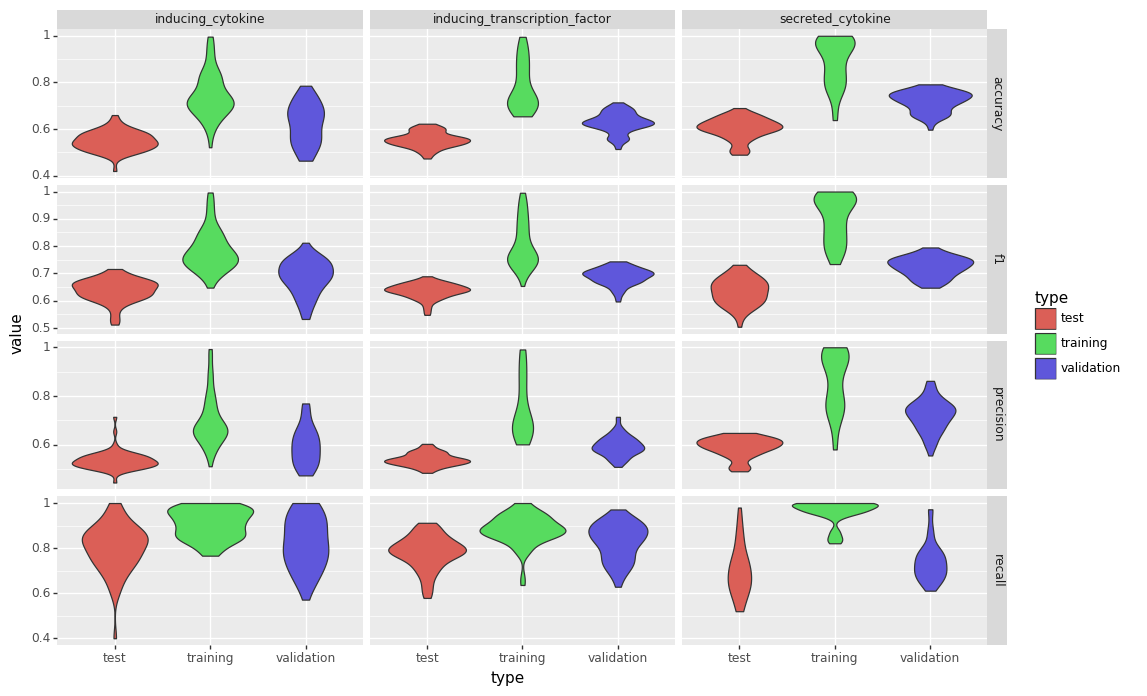

In [18]:
show_cell(NB_DEV_GRID, 'scoredist')

### tl;dr

The small, manually labeled datasets were used to create models with no weak supervision.  This is the baseline to which I will compare the weakly supervised "Discriminative Model".  These may also serve as labeling functions, but whether or not they help remains to be seen.  See the section below on the "Discriminative Model" for a higher level performance statistic tables.

#### BERT

I tried pulling down and running the pytorch BERT script (using sciBERT) for sequence classification on data from one of the tasks but it wasn't learning anything (predictions always negative).  Some further things to try here:

- Figure out how to tune that script 
- Compare vanilla BERT to sciBERT for these tasks?
- Compare results from head trained on CLS vector to results from token embeddings extracted as features and fed into an LSTM (my bet is on the latter working much better for RE)

<h1><a id='weak-supervision'>Weak Supervision</a></h1>

The weak supervision model (aka "Discriminative Model") is the final classifier trained on the large set of weak labels from the Snorkel generative model.

The notebook that trains this model (well, currently a grid of models) is {{plink(NB_END_TRAIN, use_path_name=True)}}.

This model is trained on the ```train``` split of the data, evaluated on the ```test``` split and stopped based on performance for the ```val``` split.  This is the same procedure used in the section above on building supervised models for the ```dev``` split of the data, with the only difference being that the ```train``` split (i.e. candidates with weak labels) are used for training rather than the ```dev``` split (i.e. candidates with gold labels).

A hyperparameter seach was used with an identical grid to the section above.

### Results

In order to compare the results from weak supervision in context, the score summaries below show F1 and precision scores for the following:

1. Strongly supervised, sentence-level models that take ONLY **labeling function outputs** as features and predict labels only for splits with gold annotations (these do not rely on sequence inputs as shown in the features of the above "Strong Supervision" section -- all features are simply the -1, 0, or 1 outputs of LFs)
2. Strongly supervised RNN models trained on the same data as the sentence-level models
3. The weakly supervised RNN models

All of the following represent the scores at the maximum validation F1 score found when using the ```DEV``` split as training data (or the ```TRAIN``` split in the weakly-supervised case), the ```VAL``` split for validation, and the ```TEST``` split for test data: 


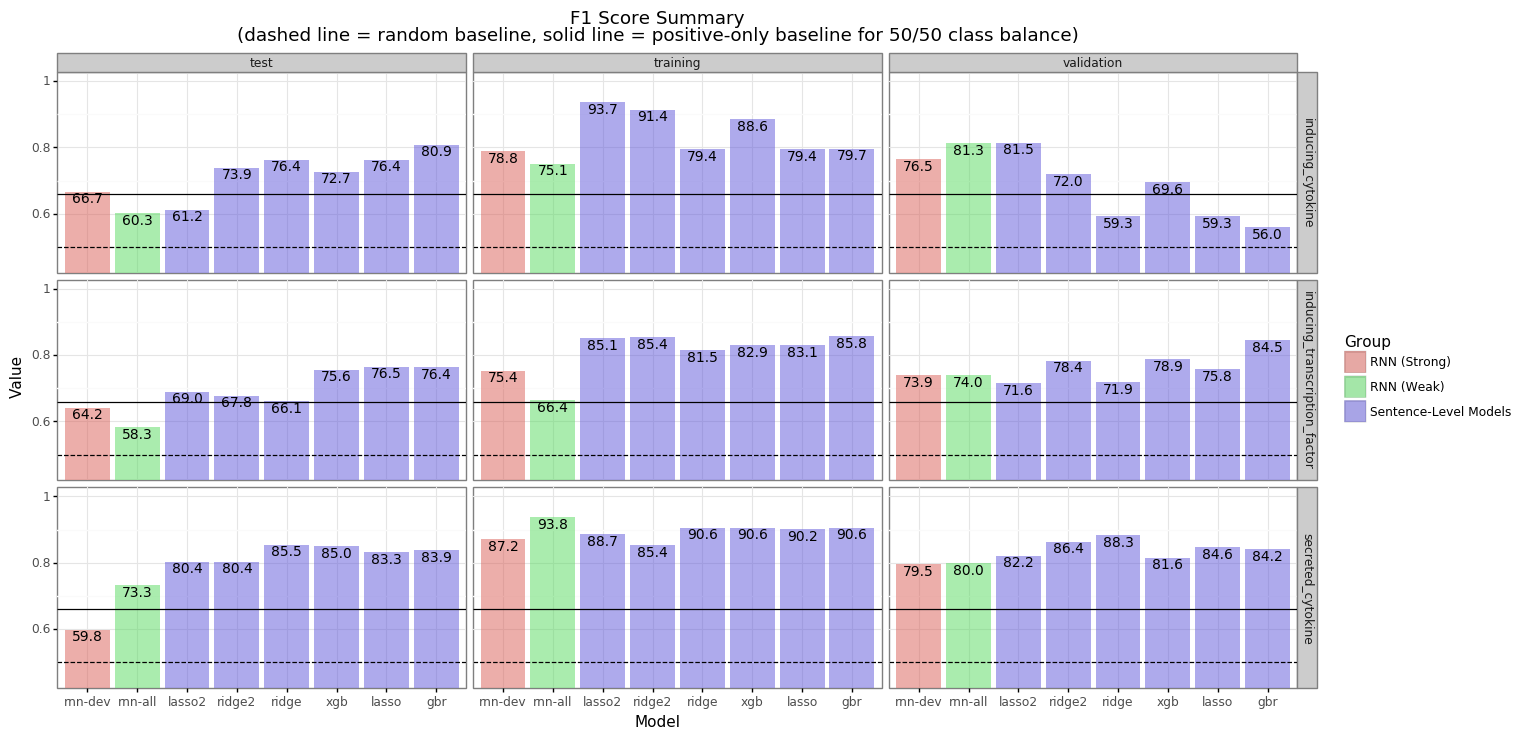

In [22]:
show_cell(NB_ANALYSIS_SCORES, 'f1')


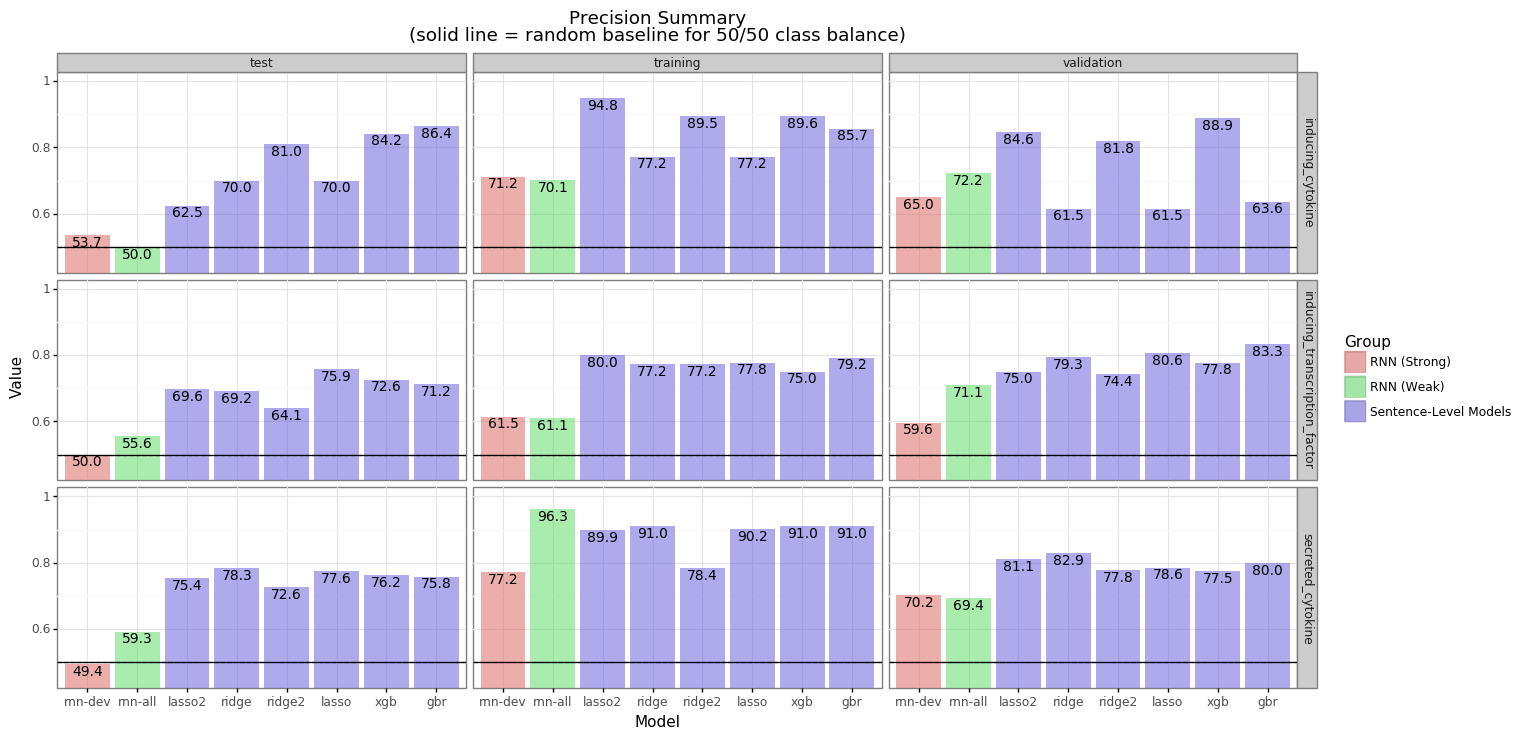

In [23]:
show_cell(NB_ANALYSIS_SCORES, 'precision')

**Conclusion**: The sentence-level models are very reliably out-performing the RNN models, weakly-supervised or otherwise, despite the fact that both are utilizing the same information provided by the labeling functions.

<h1><a id='relation-extraction'>Relation Extraction</a></h1>

TBD

- Explain how final model is applied
- Share resulting stats and visuals
- iX comparison

<h1><a id='todo'>TODO</a></h1>

from https://github.com/hammerlab/t-cell-relation-extraction/issues/4: 

- Add stats on intersception by doc id between dev and primary corpus
- Some summary information might be useful for each category of entity. How many entities and surface forms for each entity? How many novel entities and surface forms come from manual entry versus the external ontology?
- Some discussion of the various sentence segmentation and tokenization challenges of the scientific domain might be useful, with a pointer to the ScispaCy benchmarks. I think the move towards subword tokenization with WordPiece as used by SciBERT might also deserve some discussion
- It would be fun to roll up the data from the In [632] plot to the level of CD8+ vs. CD4+ T cells or even T cells in general to see which markers are used the most. We should also be able to compute the markers that best distinguish cell types from this data and compare to the marker lists you found in the OMIP Flow Repository entries.
- As discussed in person yesterday, it's probably best to quantify how our tokenization + discarding non-surface marker tokens strategy works by comparing it to the performance of the NormCo-inspired embed all tokens and add embedded vectors strategy for mapping entity mentions to CL terms

<hr>

### Rendering

To render this notebook for github (necessary to substitute variables embedded in markdown):

```bash
cd $REPO_DIR/results
jupyter nbconvert --to notebook --execute summary.ipynb --output summary.render.ipynb
```